In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import shutil

BASE_PATH = "/content/drive/MyDrive/datasets for AI KYC compliance"

paths = {
    "Aadhaar": [
        "/content/drive/MyDrive/new_generated_aadharcard_images",
        f"{BASE_PATH}/Aadhar Detection/aadhar(1593)"
    ],
    "PAN": [
        "/content/drive/MyDrive/pandata/train/images",
        f"{BASE_PATH}/Pan Card Detection/pan card(949)"
    ],
    "Passport": [
        f"{BASE_PATH}/Passport Detection/passport(289)"
    ],
    "Negative": [
        f"{BASE_PATH}/Aadhar Detection/non_aadhar(544)",
        f"{BASE_PATH}/Pan Card Detection/non pan card(544)",
        f"{BASE_PATH}/Passport Detection/non passport(334)"
    ]
}


In [4]:
LOCAL_DATASET = "/content/dataset"

os.makedirs(LOCAL_DATASET, exist_ok=True)

for label in paths:
    os.makedirs(os.path.join(LOCAL_DATASET, label), exist_ok=True)


In [5]:
from tqdm import tqdm

def copy_images():
    for label, folder_list in paths.items():
        print(f"\nCopying {label} images...")

        for folder in folder_list:
            if not os.path.exists(folder):
                print(f"Skipping missing folder: {folder}")
                continue

            for file in tqdm(os.listdir(folder)):
                src = os.path.join(folder, file)
                dst = os.path.join(LOCAL_DATASET, label, file)

                if os.path.isfile(src):
                    # Avoid overwriting duplicates
                    if not os.path.exists(dst):
                        shutil.copy2(src, dst)

copy_images()



Copying Aadhaar images...


100%|██████████| 1593/1593 [00:55<00:00, 28.45it/s] 



Copying PAN images...


100%|██████████| 949/949 [00:27<00:00, 34.78it/s] 



Copying Passport images...


100%|██████████| 289/289 [00:28<00:00, 10.24it/s]



Copying Negative images...


100%|██████████| 334/334 [00:00<00:00, 2889.65it/s]


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64  # Good for T4 GPU

train_ds = tf.keras.utils.image_dataset_from_directory(
    LOCAL_DATASET,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    LOCAL_DATASET,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)


Found 5849 files belonging to 4 classes.
Using 4680 files for training.
Found 5849 files belonging to 4 classes.
Using 1169 files for validation.
Classes: ['Aadhaar', 'Negative', 'PAN', 'Passport']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [9]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze initially

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [11]:
import keras

callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",  # Save in .keras format
        monitor="val_accuracy",       # Monitor validation accuracy
        save_best_only=True,          # Save only the best model
        mode="max",                   # 'max' because higher accuracy is better
        verbose=1                     # Print messages when saving
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8667 - loss: 0.3699
Epoch 1: val_accuracy improved from -inf to 0.96407, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.8677 - loss: 0.3674 - val_accuracy: 0.9641 - val_loss: 0.1582 - learning_rate: 0.0010
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9843 - loss: 0.0479
Epoch 2: val_accuracy improved from 0.96407 to 0.98375, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9843 - loss: 0.0479 - val_accuracy: 0.9837 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9848 - loss: 0.0425
Epoch 3: val_accuracy did not improve from 0.98375
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.9848 - loss: 0.0426 - val_accuracy: 0.9820 - val_loss: 0.0647 - learning_rate: 0.0010
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9911 - loss: 0.0270
Epoch 4: 

In [12]:
pip install gradio

In [13]:
print("Evaluating the trained model on the validation set...")
loss, accuracy = model.evaluate(val_ds)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Evaluating the trained model on the validation set...
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9890 - loss: 0.0394
Validation Loss: 0.0345
Validation Accuracy: 0.9889


In [14]:
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the best trained model
try:
    model = keras.models.load_model('best_model.keras')
    print("Successfully loaded best_model.keras")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_model.keras' exists and the model was saved correctly.")

# Assuming IMG_SIZE and class_names are already defined from previous cells
# If not, you might need to re-define them or load them from a config file.
# For now, let's use the values from the kernel state.

# IMG_SIZE = (224, 224) # Already in kernel state
# class_names = ['Aadhaar', 'Negative', 'PAN', 'Passport'] # Already in kernel state

def preprocess_image(image):
    """Preprocesses an image for model prediction."""
    img = image.resize(IMG_SIZE) # Resize image
    img = np.array(img).astype(np.float32) # Convert to numpy array and float32
    img = tf.expand_dims(img, axis=0) # Add batch dimension
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img) # Apply EfficientNetV2 preprocessing
    return img

Successfully loaded best_model.keras


In [15]:
def predict_image(image):
    """Makes a prediction on the uploaded image."""
    if image is None:
        return "No image uploaded", 0.0

    preprocessed_img = preprocess_image(image)
    predictions = model.predict(preprocessed_img)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions, axis=1)[0]

    predicted_label = class_names[predicted_class_idx]

    return f"Predicted Class: {predicted_label}", f"Confidence: {confidence:.2f}"

In [16]:
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=["text", "text"],
    title="Document Classifier",
    description="Upload an Aadhaar, PAN, Passport, or Negative image to get a classification.",
    examples=[
        # Add example image paths here if you have any accessible locally in Colab
        # e.g., "/content/dataset/Aadhaar/example_aadhaar.jpg",
        # "/content/dataset/PAN/example_pan.jpg"
    ]
)

interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3e74fff1eab4b8bd2d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3e74fff1eab4b8bd2d.gradio.live


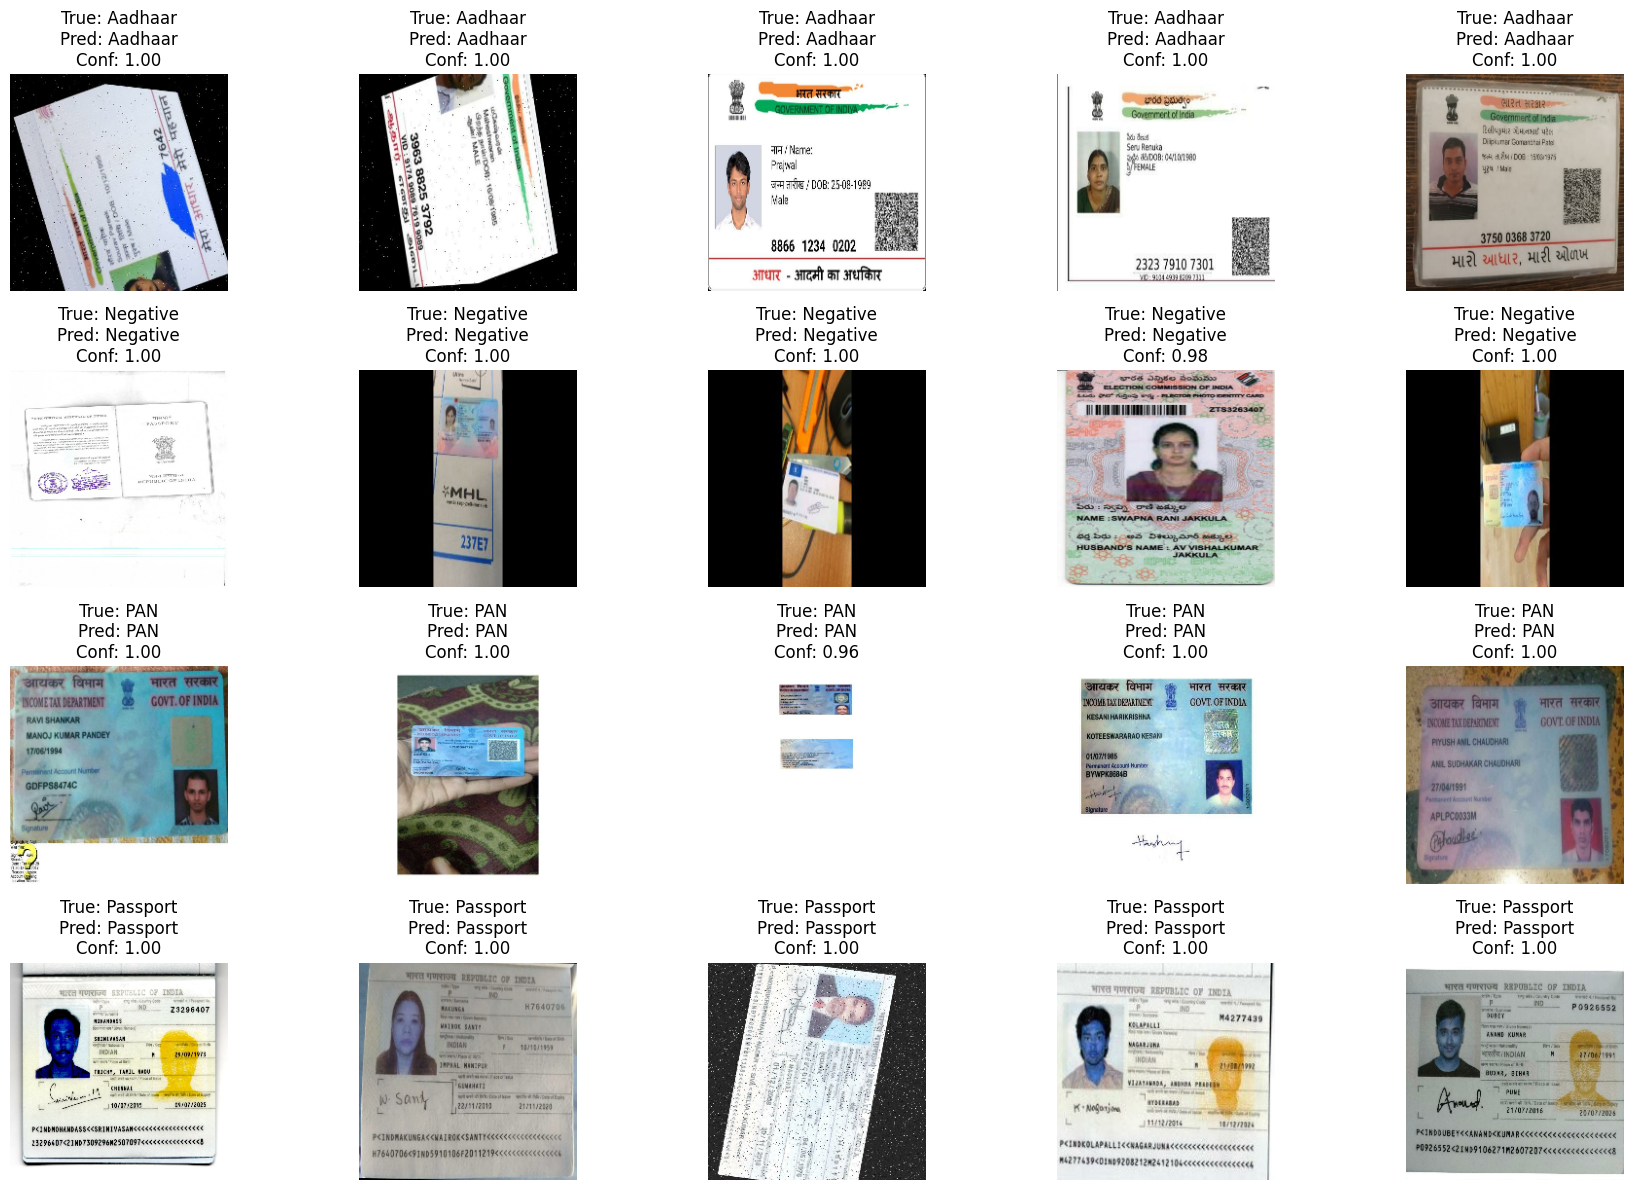

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Number of samples per class
num_samples = 5
samples = {name: [] for name in class_names}

# Collect 5 samples per class
for images, labels in val_ds:
    for img, label in zip(images, labels):
        label = label.numpy()
        class_name = class_names[label]

        if len(samples[class_name]) < num_samples:
            samples[class_name].append(img.numpy())

    if all(len(v) >= num_samples for v in samples.values()):
        break

# Combine samples
all_images = [(img, class_names.index(cls))
              for cls, imgs in samples.items()
              for img in imgs]

# Plot
plt.figure(figsize=(18, 12))

for i, (img_array, true_idx) in enumerate(all_images):
    image = Image.fromarray(img_array.astype(np.uint8))
    true_label = class_names[true_idx]

    pred = model.predict(preprocess_image(image), verbose=0)
    pred_idx = np.argmax(pred)
    confidence = np.max(pred)
    pred_label = class_names[pred_idx]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()